In [1]:
import os
os.getcwd()
os.chdir('/home/jecosine/Courses/Courses/COMP8800/Projects/CatBoostPlayground')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from allib.datasets import load_uci
from allib.metrics.distance import AVAIL_DIST_METRICS

In [2]:
def get_cache_name(alstrategy, dsn, model, stg, metric, encode, suffix):
    return f"{dsn.replace('/', '_')}@{model}@{stg}_{metric}_{encode}@{suffix}@x20.pkl"

def load_dataset(dsn: str):
    ds = load_uci(dsn)
    ds.with_preprocess(
        steps=[
            "sample_n", 
            # "categorical_only",
            # "continuous_to_categorical",
            "remove_constant_columns", 
            "drop_duplicate_rows"
        ],  
        params_list=[
            {"n": 1000, "random_state": 0},
            # {"encode": "ordinal"},
            # {},
            {}, 
            {}
        ], 
        in_place=True
    )
    # for col in ds._data.columns:
    #     if ds._data[col].dtype == "category":
    #         ds._data[col] = ds._data[col].astype("category").cat.codes.astype("int")
    # ds._data.reset_index(drop=True, inplace=True)
    
    return ds

In [4]:
BASE_PATH = "app/comp_dist/ppl_cache_pred"
SUFFIX = "200iter_numonly_wo_n"
ALSTRATEGY = "typiclust"
ENCODE="ordinal_wo_n"

In [6]:
from sklearn.metrics import f1_score
import pickle

dsn = "adult"
candidates = ["euclidean", "cosine", "hamming", "smirnov", "goodall1", "iof", "anderberg", "gambaryan"]
# candidates = ["euclidean", "cosine"]
all_dis = candidates
metrics_n_times = []
ds = load_dataset(dsn)
# read random baseline
cache_name = get_cache_name(ALSTRATEGY, dsn, "catboost", "random", "cosine", "ordinal_wo_n", "200iter_numonly_wo_n")
with open(os.path.join(BASE_PATH, cache_name), "rb") as f:
    stats = pickle.load(f)
bsl = np.array([[f1_score(ds.test_y, stats[i]["predictions"][j], pos_label="<=50K") for j in range(len(stats[i]["instances"]))] for i in range(len(stats))])
# bsl = np.array([[f1_score(ds.test_y, stats[i]["predictions"][j], average="macro") for j in range(len(stats[i]["instances"]))] for i in range(len(stats))])

for dn in all_dis:
    cache_name = get_cache_name(ALSTRATEGY, dsn, "catboost", ALSTRATEGY, dn, ENCODE, SUFFIX)
    if os.path.exists(os.path.join(BASE_PATH, cache_name)):
        print(f"Loading {cache_name}")
        with open(os.path.join(BASE_PATH, cache_name), "rb") as f:
            stats = pickle.load(f)
        metrics_n_times.append([[f1_score(ds.test_y, stats[i]["predictions"][j], pos_label="<=50K") for j in range(len(stats[i]["instances"]))] for i in range(len(stats))])

# for dn in all_dis:
#     cache_name = get_cache_name(ALSTRATEGY, dsn, "catboost", ALSTRATEGY, dn, ENCODE, SUFFIX)
#     if os.path.exists(os.path.join(BASE_PATH, cache_name)):
#         print(f"Loading {cache_name}")
#         with open(os.path.join(BASE_PATH, cache_name), "rb") as f:
#             stats = pickle.load(f)
#         metrics_n_times.append([[f1_score(ds.test_y, stats[i]["predictions"][j], pos_label="<=50K") for j in range(len(stats[i]["instances"]))] for i in range(len(stats))])

Loading adult@catboost@typiclust_euclidean_ordinal_wo_n@200iter_numonly_wo_n@x20.pkl
Loading adult@catboost@typiclust_cosine_ordinal_wo_n@200iter_numonly_wo_n@x20.pkl
Loading adult@catboost@typiclust_hamming_ordinal_wo_n@200iter_numonly_wo_n@x20.pkl
Loading adult@catboost@typiclust_smirnov_ordinal_wo_n@200iter_numonly_wo_n@x20.pkl
Loading adult@catboost@typiclust_goodall1_ordinal_wo_n@200iter_numonly_wo_n@x20.pkl
Loading adult@catboost@typiclust_iof_ordinal_wo_n@200iter_numonly_wo_n@x20.pkl
Loading adult@catboost@typiclust_anderberg_ordinal_wo_n@200iter_numonly_wo_n@x20.pkl
Loading adult@catboost@typiclust_gambaryan_ordinal_wo_n@200iter_numonly_wo_n@x20.pkl


In [183]:
for dn in all_dis:
    cache_name = get_cache_name(ALSTRATEGY, dsn, "catboost", "typiclust", dn, "ordinal_wo_n", "200iter_catonly_wo_n")
    if os.path.exists(os.path.join(BASE_PATH, cache_name)):
        print(f"Loading {cache_name}")
        with open(os.path.join(BASE_PATH, cache_name), "rb") as f:
            stats = pickle.load(f)
        metrics_n_times.append([[f1_score(ds.test_y, stats[i]["predictions"][j], pos_label="<=50K") for j in range(len(stats[i]["instances"]))] for i in range(len(stats))])

Loading adult@catboost@typiclust_euclidean_ordinal_wo_n@200iter_catonly_wo_n@x20.pkl
Loading adult@catboost@typiclust_cosine_ordinal_wo_n@200iter_catonly_wo_n@x20.pkl


In [165]:
cache_name = get_cache_name(ALSTRATEGY, dsn, "catboost", "random", "cosine", ENCODE, SUFFIX)

In [7]:
metrics_n_times = np.array(metrics_n_times)
bk = metrics_n_times.copy()
metrics_n_times.shape

(8, 20, 20)

In [8]:
instances = stats[0]["instances"]

In [9]:
metrics_n_times = bk
x = np.array([metrics_n_times[i].mean(axis=0) for i in range(len(metrics_n_times))])
std = np.array([metrics_n_times[i].std(axis=0) for i in range(len(metrics_n_times))]) / np.sqrt(metrics_n_times.shape[1])
l, u = x-std, x+std
bsl_mean = bsl.mean(axis=0)
bsl_std = bsl.std(axis=0) / np.sqrt(bsl.shape[1])
bsl_l, bsl_u = bsl_mean-bsl_std, bsl_mean+bsl_std

In [10]:
from scipy.interpolate import make_interp_spline 
def intp(x, y, k=3):
    return make_interp_spline(x, y, k)

/tmp/ipykernel_97926/3048864872.py:1: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


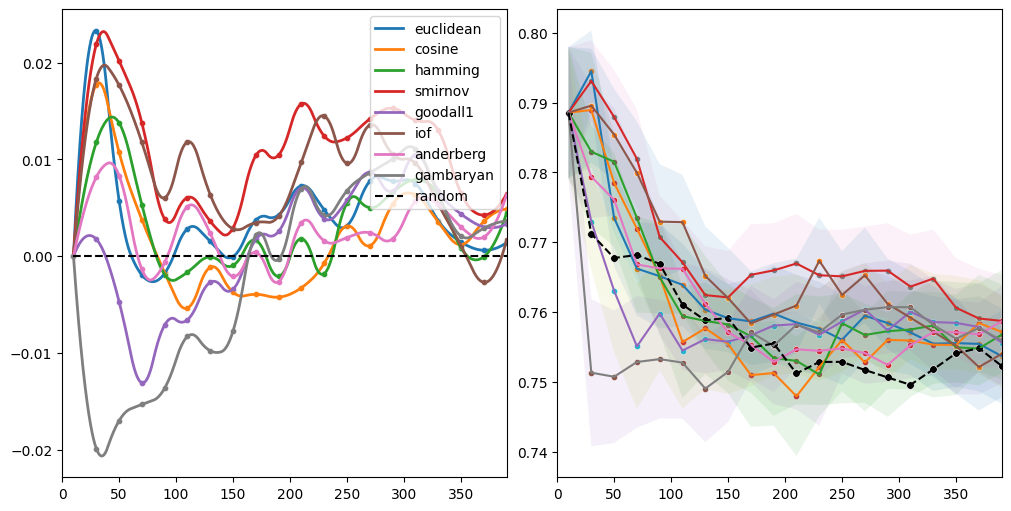

In [12]:
from scipy.ndimage.filters import gaussian_filter1d
axd = plt.figure(constrained_layout=True, figsize=(10, 5)).subplot_mosaic(
    """
    AB
    """
)
# metrics_n_times = bk
# metrics_n_times = np.array([np.mean(metrics_n_times[i], axis=1) for i in range(len(metrics_n_times))])
# # metrics_n_times - np.median(bsl, axis=1)
# m = np.median(bsl, axis=1)
def g(x):
    return gaussian_filter1d(x, sigma=0.5)

# labels = ["euclidean+gambaryan", "cosine+gambaryan", "euclidean", "cosine"]
labels = candidates
# plt.figure(figsize=(10, 6))

for i in range(len(x)):
    # smooth the line
    X = np.linspace(10, max(instances), 1000)
    y = x[i] - bsl_mean
    y[0] = 0
    # plt.fill_between(instances, g(l[i]), g(u[i]), alpha=0.1)
    ax = sns.lineplot(ax=axd['A'], x=X, y=intp(instances, x[i]-bsl_mean, k=2)(X), label=labels[i], linewidth=2)
    sns.scatterplot(ax=axd['A'], x=instances, y=x[i]-bsl_mean, s=20)
    ax.set_xlim(0, max(instances)) 


    # sns.regplot(x=instances, y=y, scatter=False, label=all_dis[i], order=2, ci=None, x_jitter=.15)
    # sns.lineplot(x=instances, y=x[i], label=all_dis[i])
# ax.set_xticklabels([])
sns.lineplot(ax=axd['A'], x=instances, y=np.zeros_like(instances), label="random", color="black", linestyle="--")
# top right
sns.move_legend(axd['A'], "upper right")
# plt.figure(figsize=(10, 6))

for i in range(len(x)):
    # smooth the line
    X = np.linspace(10, max(instances), 1000)
    # point size = 4
    axd['B'].fill_between(instances, l[i], u[i], alpha=0.1)
    ax = sns.lineplot(ax=axd['B'], x=instances, y=x[i], label=labels[i])
    sns.scatterplot(ax=axd['B'], x=instances, y=x[i], s=20)
    
sns.lineplot(ax=axd['B'], x=instances, y=bsl_mean, label="random", color="black", linestyle="--")
sns.scatterplot(ax=axd['B'], x=instances, y=bsl_mean, s=30, color="black")
# ax.set_ylim(0.81, 0.87)
ax.set_xlim(0, max(instances)) 
# plt.title("Typiclust with KModes")
ax.legend_.remove()